# EXPLORATION 14

# 14. 어제 오른 내 주식, 과연 내일은?

* Writier : 송영석
* Date : 2021.11.17

## STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [2]:
print(len(ts))

250


In [3]:
ts.tail()

Date
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [4]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

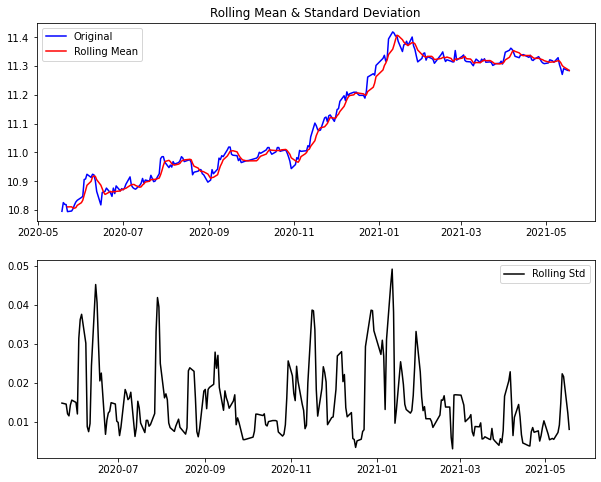

In [72]:
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    plt.figure(figsize=(10,8))
    plt.subplot(2, 1, 1)
    plt.title('Rolling Mean & Standard Deviation')
    orig = plt.plot(timeseries, color='blue',label='Original')  
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    
    plt.subplot(2, 1, 2)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    
    plt.show(block=False)
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=5)

* p-value = 0.5로 비교적 큰 값
* 안정성을 위해 시계열 분해를 해줍니다.

In [7]:
#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


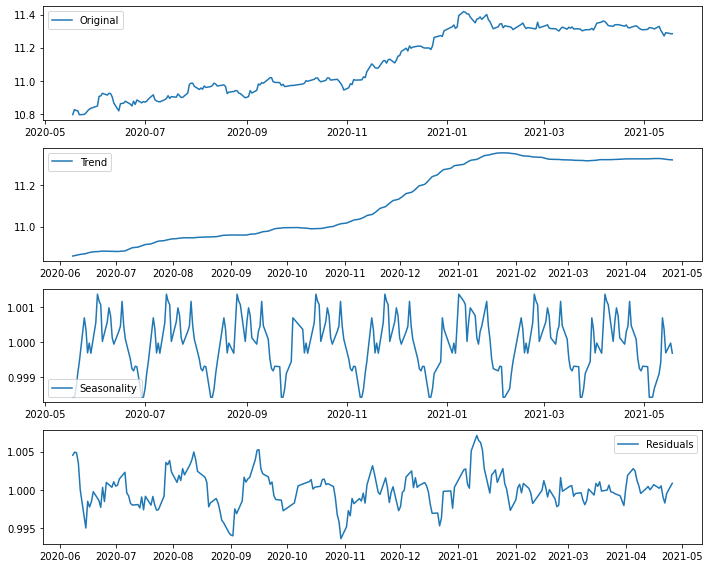

In [73]:

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


위의 Residual은 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다. 

## STEP 4 : 학습, 테스트 데이터셋 생성

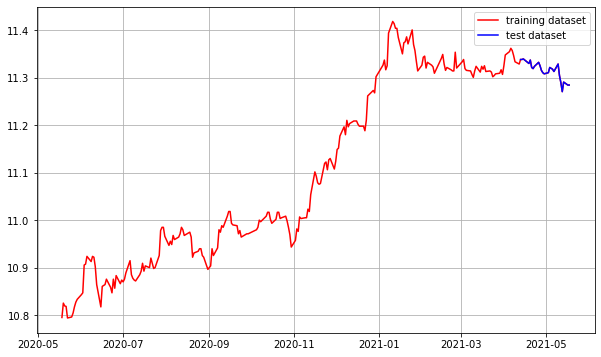

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


## STEP 5 : 적정 ARIMA 모수 찾기

* p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용
* PACF 그래프를 보면 p가 2이상 부터는 절단면 안에 있으므로 p=1과 q=0 으로 설정 

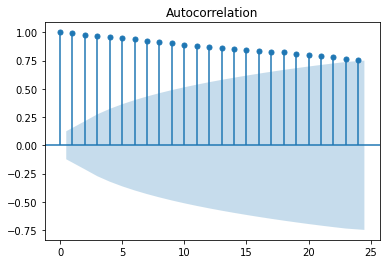

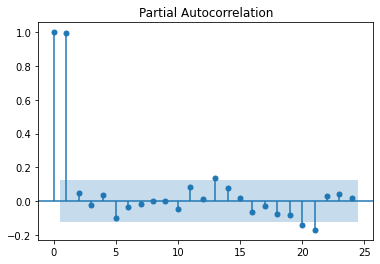

In [9]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* 1차 차분을 한 뒤 p-value도 충분히 작지만 2차 차분하였을 때 오히려 p-value가 커진 것을 보아 1차 차분 d=1로 설정

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


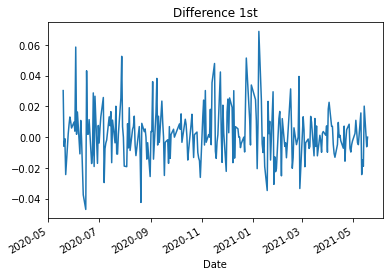

In [10]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


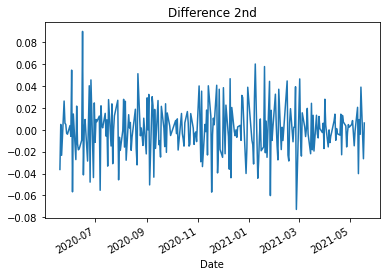

In [11]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련
* 위의 내용을 바탕으로 p=1, d=1, q=0을 모수로 가지는 ARIMA 모델

In [12]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  #(p,d,q)
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1164.792
Time:                        05:42:41   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

* 모델 테스트 및 플로팅

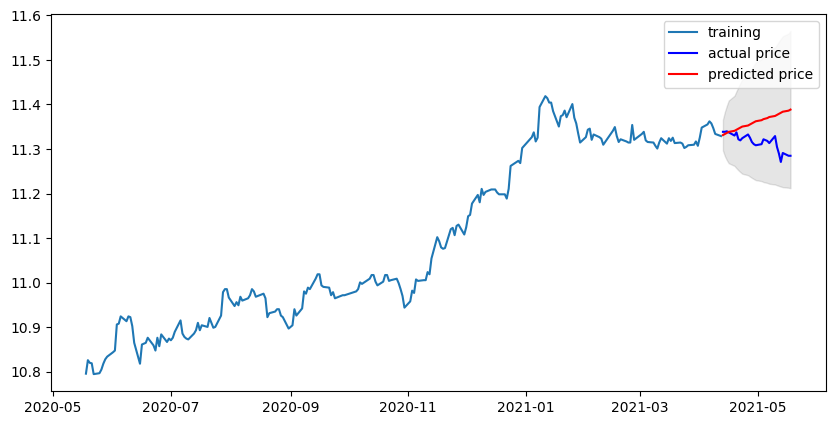

In [13]:

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


* 최종 예측 모델 정확도 측정(MAPE)
* MAPE가 약 4%로 15% 미만의 정확도로 예측 되어짐

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


## STEP 7 : 다른 주식 종목 예측해 보기

* 기존에 투자하고 있던 2종목의 예측을 추가적으로 해보았다.
* 신세계,e 마트 두종목의 1년치 데이터(2020.11.17~2021.11.17)를 yahoo finance에서 가져왔다.


In [15]:
# 이마트 time series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/emart.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_e = df['Close']

ts_e.head()

Date
2020-11-17    158500.0
2020-11-18    156500.0
2020-11-19    158000.0
2020-11-20    155500.0
2020-11-23    154500.0
Name: Close, dtype: float64

In [16]:
# 신세계 time series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/shinsegae.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_s = df['Close']

ts_s.head()

Date
2020-11-17    237000.0
2020-11-18    229500.0
2020-11-19    229000.0
2020-11-20    232000.0
2020-11-23    233500.0
Name: Close, dtype: float64

In [17]:
# 결측치 처리
ts_e=ts_e.interpolate(method='time')
ts_e[ts_e.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [18]:
# 결측치 처리
ts_s=ts_s.interpolate(method='time')
ts_s[ts_s.isna()] 

Series([], Name: Close, dtype: float64)

In [19]:
# 로그 변환 시도 
ts_log_e = np.log(ts_e)

In [20]:
# 로그 변환 시도 
ts_log_s = np.log(ts_s)

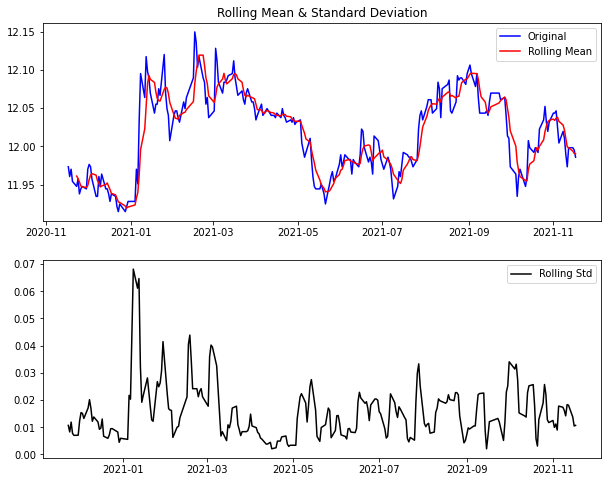

In [74]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_e, window=5)

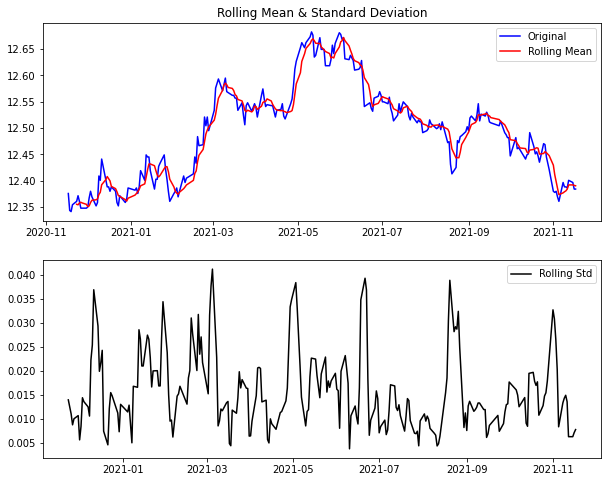

In [75]:
plot_rolling_statistics(ts_log_s, window=5)

* 두 종목 모두 p-value가 0.05 보다 크므로 시계열분해하여 안정성

In [23]:
#정량적 Augmented Dicky-Fuller Test    
augmented_dickey_fuller_test(ts_log_e)

Results of Dickey-Fuller Test:
Test Statistic                  -2.680553
p-value                          0.077464
#Lags Used                      14.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


In [24]:
augmented_dickey_fuller_test(ts_log_s)

Results of Dickey-Fuller Test:
Test Statistic                  -1.675332
p-value                          0.443865
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


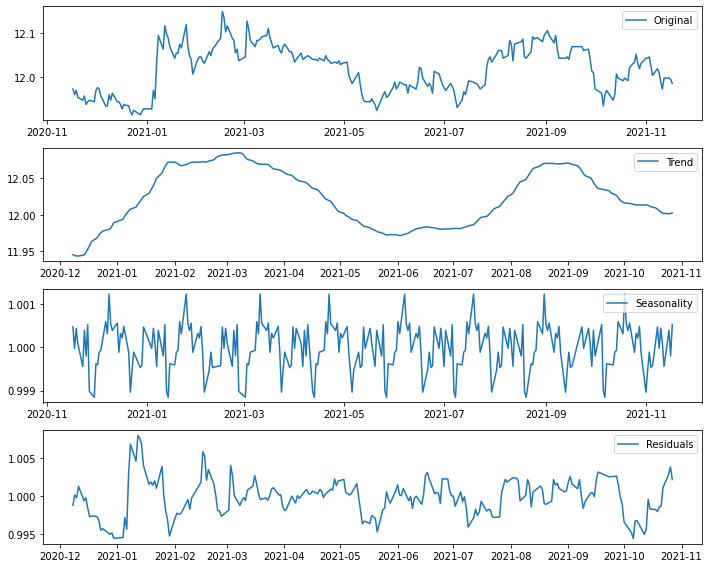

In [76]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_e = seasonal_decompose(ts_log_e, model='multiplicative', period = 30) 

trend_e = decomposition_e.trend
seasonal_e = decomposition_e.seasonal
residual_e = decomposition_e.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ts_log_e, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_e, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_e,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_e, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

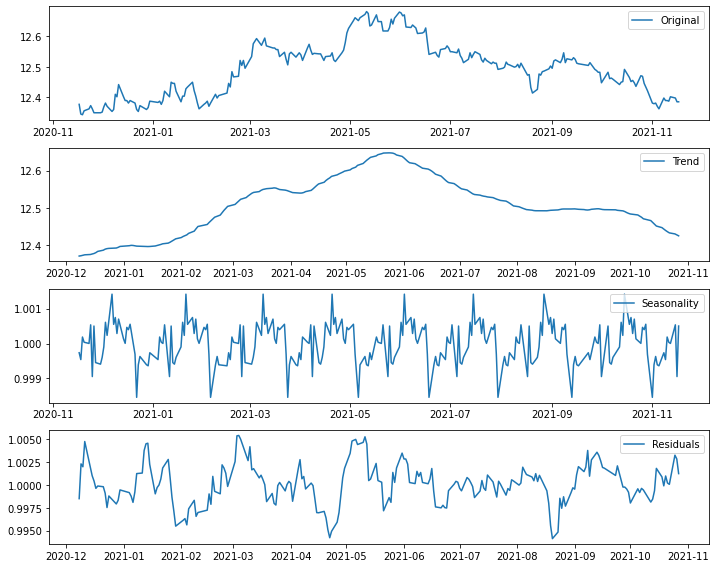

In [77]:
decomposition_s = seasonal_decompose(ts_log_s, model='multiplicative', period = 30) 

trend_s = decomposition_s.trend
seasonal_s = decomposition_s.seasonal
residual_s = decomposition_s.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ts_log_s, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_s, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_s,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_s, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* p-value 감소 확인 


In [28]:
# Residual 안정성 확인
residual_e.dropna(inplace=True)
augmented_dickey_fuller_test(residual_e)

Results of Dickey-Fuller Test:
Test Statistic                  -5.184709
p-value                          0.000009
#Lags Used                      14.000000
Number of Observations Used    203.000000
Critical Value (1%)             -3.462980
Critical Value (5%)             -2.875885
Critical Value (10%)            -2.574416
dtype: float64


In [30]:
residual_s.dropna(inplace=True)
augmented_dickey_fuller_test(residual_s)

Results of Dickey-Fuller Test:
Test Statistic                -5.935979e+00
p-value                        2.320463e-07
#Lags Used                     1.000000e+01
Number of Observations Used    2.070000e+02
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


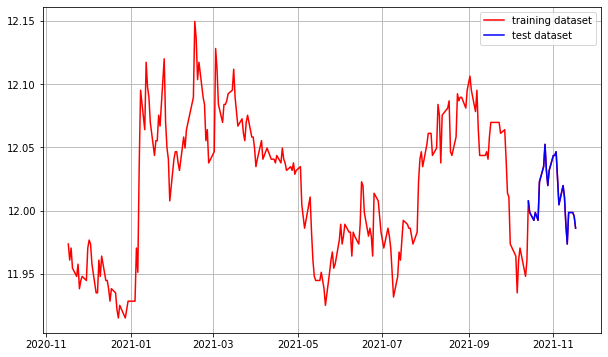

In [32]:
train_data_e, test_data_e = ts_log_e[:int(len(ts_log_e)*0.9)], ts_log_e[int(len(ts_log_e)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_e, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_e, c='b', label='test dataset')
plt.legend()

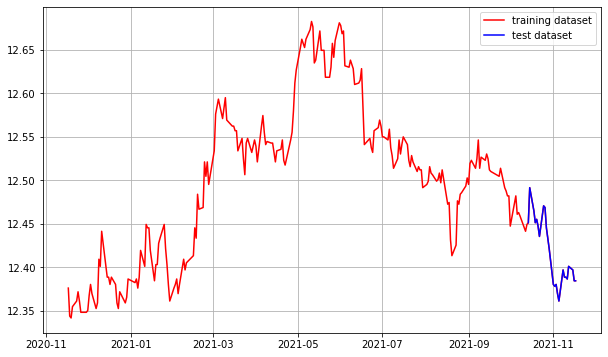

In [33]:
train_data_s, test_data_s = ts_log_s[:int(len(ts_log_s)*0.9)], ts_log_s[int(len(ts_log_s)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_s, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_s, c='b', label='test dataset')
plt.legend()

* 두 종목의 ACF,PACF를 확인하여 p,q값 확인
* 2 지점 부터 0에 가까운 값을 두 그래프 모두 보여서 p = 1, q = 0 사용

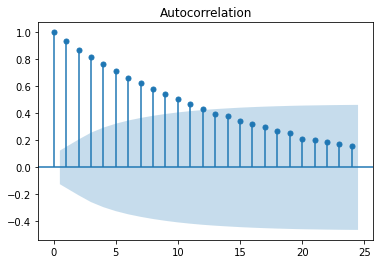

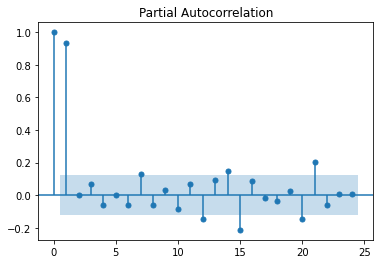

In [34]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_e)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_e)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

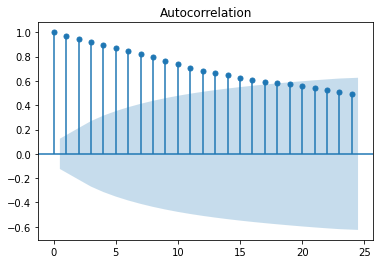

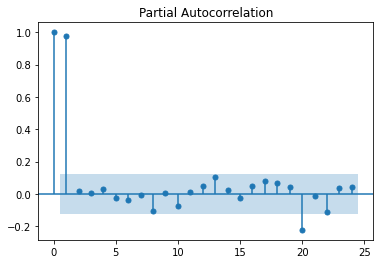

In [35]:
plot_acf(ts_log_s)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_s)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* 두 종목 모두 1차 차분만 하여도 낮은 p-value를 보여 d=1 사용

Results of Dickey-Fuller Test:
Test Statistic                  -4.409011
p-value                          0.000286
#Lags Used                      13.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


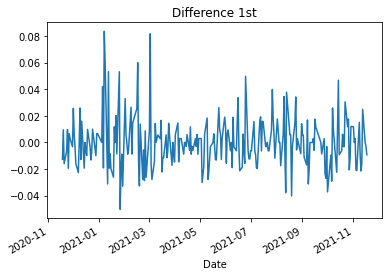

In [36]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1_e = ts_log_e.diff(periods=1).iloc[1:]
diff_1_e.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_e)

Results of Dickey-Fuller Test:
Test Statistic                -1.710814e+01
p-value                        7.397406e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


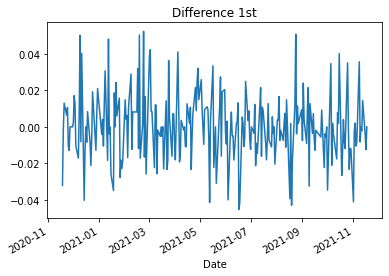

In [37]:
diff_1_s = ts_log_s.diff(periods=1).iloc[1:]
diff_1_s.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_s)

In [43]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model_e = ARIMA(train_data_e, order=(1, 1, 0))  
fitted_m_e = model_e.fit(disp=-1)  
print(fitted_m_e.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 559.788
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 18 Nov 2021   AIC                          -1113.576
Time:                        06:15:18   BIC                          -1103.368
Sample:                             1   HQIC                         -1109.455
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.727e-05      0.001     -0.046      0.963      -0.002       0.002
ar.L1.D.Close    -0.0526      0.067     -0.785      0.433      -0.184       0.079
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

In [47]:
model_s = ARIMA(train_data_s, order=(1, 1, 0))  
fitted_m_s = model_s.fit(disp=-1)  
print(fitted_m_s.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 571.737
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1137.475
Time:                        06:17:53   BIC                          -1127.267
Sample:                             1   HQIC                         -1133.353
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.298      0.766      -0.002       0.003
ar.L1.D.Close    -0.0870      0.067     -1.295      0.195      -0.219       0.045
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

###  이마트와 신세계 종모 모두 ARIMA를 통해 예측 후 그래프 확인
* 두 종목 모두 MAPE 약 4~5%로 기준치인 15%미만의 정확도로 예측 되었습니다. 


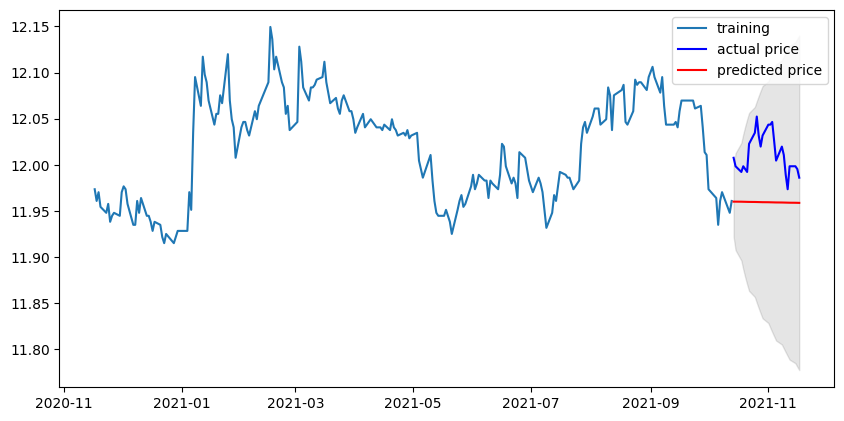

In [44]:
# Forecast : 결과가 fc에 담깁니다. 
fc_e, se_e, conf_e = fitted_m_e.forecast(len(test_data_e), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_e = pd.Series(fc_e, index=test_data_e.index)   # 예측결과
lower_series_e = pd.Series(conf_e[:, 0], index=test_data_e.index)  # 예측결과의 하한 바운드
upper_series_e = pd.Series(conf_e[:, 1], index=test_data_e.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_e, label='training')
plt.plot(test_data_e, c='b', label='actual price')
plt.plot(fc_series_e, c='r',label='predicted price')
plt.fill_between(lower_series_e.index, lower_series_e, upper_series_e, color='k', alpha=.10)
plt.legend()
plt.show()


In [45]:
mse_e = mean_squared_error(np.exp(test_data_e), np.exp(fc_e))
print('MSE: ', mse_e)

mae_e = mean_absolute_error(np.exp(test_data_e), np.exp(fc_e))
print('MAE: ', mae_e)

rmse_e = math.sqrt(mean_squared_error(np.exp(test_data_e), np.exp(fc_e)))
print('RMSE: ', rmse_e)

mape_e = np.mean(np.abs(np.exp(fc_e) - np.exp(test_data_e))/np.abs(np.exp(test_data_e)))
print('MAPE: {:.2f}%'.format(mape_e*100))

MSE:  85545536.06956859
MAE:  8557.53420778354
RMSE:  9249.082985332578
MAPE: 5.15%


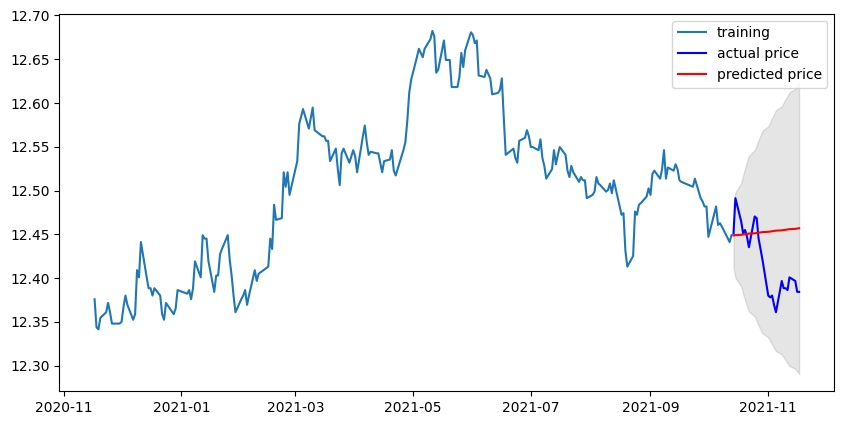

In [48]:
# Forecast : 결과가 fc에 담깁니다. 
fc_s, se_s, conf_s = fitted_m_s.forecast(len(test_data_s), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_s = pd.Series(fc_s, index=test_data_s.index)   # 예측결과
lower_series_s = pd.Series(conf_s[:, 0], index=test_data_s.index)  # 예측결과의 하한 바운드
upper_series_s = pd.Series(conf_s[:, 1], index=test_data_s.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_s, label='training')
plt.plot(test_data_s, c='b', label='actual price')
plt.plot(fc_series_s, c='r',label='predicted price')
plt.fill_between(lower_series_s.index, lower_series_s, upper_series_s, color='k', alpha=.10)
plt.legend()
plt.show()


In [49]:
mse_s = mean_squared_error(np.exp(test_data_s), np.exp(fc_s))
print('MSE: ', mse_s)

mae_s = mean_absolute_error(np.exp(test_data_s), np.exp(fc_s))
print('MAE: ', mae_s)

rmse_s = math.sqrt(mean_squared_error(np.exp(test_data_s), np.exp(fc_s)))
print('RMSE: ', rmse_s)

mape_s = np.mean(np.abs(np.exp(fc_s) - np.exp(test_data_s))/np.abs(np.exp(test_data_s)))
print('MAPE: {:.2f}%'.format(mape_s*100))

MSE:  173482741.57092628
MAE:  10917.087796350592
RMSE:  13171.284735018307
MAPE: 4.52%


# 회고


1. 평소 투자하던 종목을 야후 finance의 자료를 이용해 데이터 분석을 해보는 복습을 할 수 있어서 의미있었습니다.
2. 가설 검정 p-value의 의미를 다시 한번 알게 되었고 시계열 분해를 통해 안정성을 확보하는 방법 또한 익혔습니다.
3. ACF,PACF를 이용해 p,q 모수 추정이 거의 비슷한 점이 의문이 들어 여러 자료를 찾아 보았지만 틀린 점을 찾지 못하여 사용하였습니다.
4. 기준치보다 모델정확도가 잘 나온 것을 통해 앞으로의 투자 방향을 ARIMA로 설정해보는 과정 또한 의미있을것 같습니다.